In [1]:
#Compiling Data
import pandas as pd
tweetdata=pd.read_csv("datasets/trump-tweets-kaggle/trump-tweets.csv")
tweetdata['date'] = pd.to_datetime(tweetdata['date'])
tweetdata['time'] = tweetdata['date'].dt.time
tweetdata['hour'] = tweetdata['date'].dt.strftime('%H')
tweetdata['min'] = tweetdata['date'].dt.strftime('%M')
tweetdata['hour']=pd.to_numeric(tweetdata['hour'])
tweetdata['min']=pd.to_numeric(tweetdata['min'])
tweetdata['hour']=tweetdata['hour']+(tweetdata['min'])/60
tweetdata['date'] = pd.to_datetime(tweetdata['date']).dt.strftime('%m/%d/%Y')
tre_rate_data=pd.read_table("datasets/us-gov-historical-yield-curve/YieldCurve.txt",sep="\t")
tre_rate_data['Date'] = pd.to_datetime(tre_rate_data['Date']).dt.strftime('%m/%d/%Y')

Tweet_rate = pd.merge(left=tweetdata , right=tre_rate_data, left_on='date', right_on='Date')
Tweet_rate=Tweet_rate.drop(['id','link','retweets','favorites','mentions','hashtags','geo','Date','min','time'],axis=1)
import numpy as np
df1=np.array(Tweet_rate['1 Mo'])
df1_log=[]
for x in range(len(df1)-1):
    if Tweet_rate['hour'][x]>15:
        if df1[x+1]>df1[x]:
            df1_log.append('up')
        elif df1[x+1]<df1[x]:
            df1_log.append('down')
        else:
            df1_log.append('neutral')
    else:
        if df1[x]>df1[x-1]:
            df1_log.append('up')
        elif df1[x]<df1[x-1]:
            df1_log.append('down')
        else:
            df1_log.append('neutral')
df11_log=df1[1:]-df1[:-1]
Tweet_rate=Tweet_rate[1:]
Tweet_rate['1 Mo flag']=df1_log
Tweet_rate['1 Mo pric diff']=df11_log
Tweet_rate = Tweet_rate[['date','hour','content','1 Mo','1 Mo flag','1 Mo pric diff']]

In [2]:
import nltk
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/pbhootra/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/pbhootra/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [3]:
from nltk.corpus import wordnet

def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

import string
import re
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer

def clean_text(text):
    # lower text
    text = text.lower()
    # remove usernames
    text = [word for word in text.split(" ") if not word.startswith("@")]
    # remove hyperlinks
    text = [word for word in text if not re.match(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", word)]
    # tokenize text and remove puncutation
    text = [word.strip(string.punctuation) for word in text]
    # remove words that contain numbers
    text = [word for word in text if not any(c.isdigit() for c in word)]
    # remove stop words
    with open("datasets/stopwords.txt") as f:
        stopwords = f.read()
        text = [x for x in text if x not in stopwords]
    # remove empty tokens
    text = [t for t in text if len(t) > 2]
    # pos tag text
    pos_tags = pos_tag(text)
    # lemmatize text
    text = [WordNetLemmatizer().lemmatize(t[0], get_wordnet_pos(t[1])) for t in pos_tags]
    # remove words with only one letter
    text = [t for t in text if len(t) > 1]
    # join all
    text = " ".join(text)
    return(text)
Tweet_rate['content_processed'] = Tweet_rate['content'].apply(lambda x: clean_text(x))

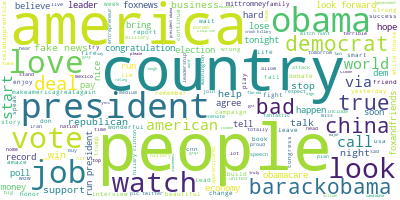

In [4]:
# Import the wordcloud library
from wordcloud import WordCloud
# Join the different processed titles together.
long_string = ','.join(list(Tweet_rate['content_processed'].values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

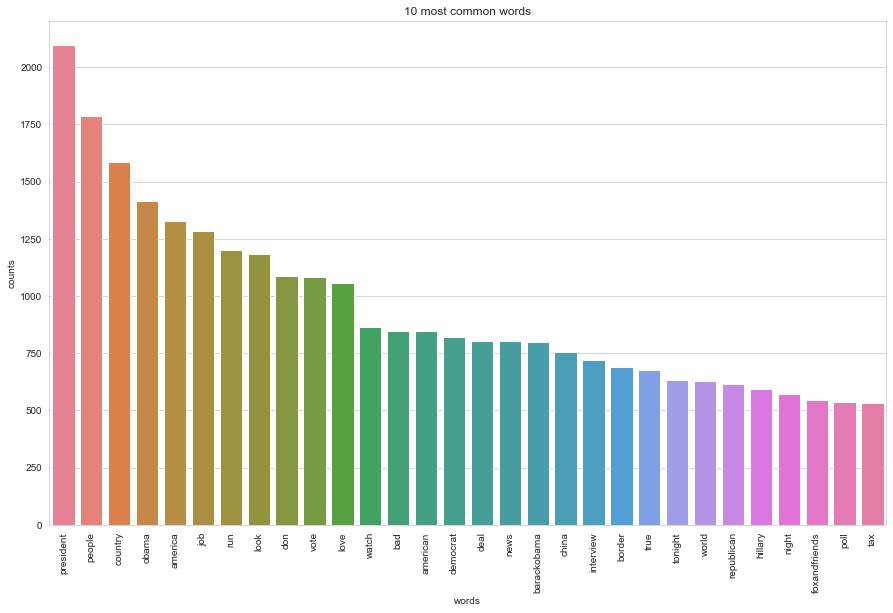

In [5]:
#NLP tagger/POS tag
#for pre-processing: delete words shorter than 4 letters
# Load the library with the CountVectorizer method
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

# Helper function
def plot_30_most_common_words(count_data, count_vectorizer):
    import matplotlib.pyplot as plt
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:30]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='10 most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()
# Initialise the count vectorizer with the English stop words
count_vectorizer = CountVectorizer(stop_words='english')
# Fit and transform the processed titles
count_data = count_vectorizer.fit_transform(Tweet_rate['content_processed'])
# Visualise the 10 most common words
plot_30_most_common_words(count_data, count_vectorizer)
import warnings
warnings.simplefilter("ignore", DeprecationWarning)

In [6]:
# Load the LDA model from sk-learn
from sklearn.decomposition import LatentDirichletAllocation as LDA
 
# Helper function
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
import os
from pyLDAvis import sklearn as sklearn_lda
import pickle 
import pyLDAvis

model_list = []

number_words = 30
for number_topics in [30]:
    # Create and fit the LDA model
    lda = LDA(n_components=number_topics, n_jobs=-1)
    lda.fit(count_data)
    # Print the topics found by the LDA model
    print("\n-----------\nTopics = " + str(number_topics) + " and Score = " + str(lda.perplexity(count_data)) + ":")
    print_topics(lda, count_vectorizer, number_words)
    model_list.append(lda)




/opt/anaconda3/lib/python3.7/site-packages/past/builtins/misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Mapping



-----------
Topics = 30 and Score = 6043.803923210724:

Topic #0:
course golf national play doral club blue miami school review monster don ivanka fall gun american john attack world spectacular party people amazing woman trumpdoral right daughter beautiful energy look

Topic #1:
fan class texas middle barackobama florida rosie air christmas gas career rise gov wisconsin scott puerto rico love family people rick leave help price hard american estate won msvivicafox energy

Topic #2:
america don country office future successful bernie barackobama save leader pennsylvania safe business debt bring vision focus supporter strong believe sander leadership love bankrupt people happen property strength mittromney entrepreneur

Topic #3:
tax cut economy record low job market unemployment stock rate history american increase budget reform growth barackobama economic raise obama spending debt defense administration country regulation big strong fast set

Topic #4:
yes press conference start read

In [7]:
# Use pyLDAvis
LDAvis_data_filepath = os.path.join('./results/ldavis_prepared_'+str(number_topics))

# this is a bit time consuming
LDAvis_prepared = sklearn_lda.prepare(model_list[0], count_data, count_vectorizer)

with open(LDAvis_data_filepath, 'wb') as f:
   pickle.dump(LDAvis_prepared, f)
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
   LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, './results/ldavis_prepared_'+ str(number_topics) +'.html')

/opt/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [8]:
# Map tweets to topic

#I choose model_list[1] where the number of topics is 10

model = model_list[0]

lda_output = model.transform(count_data)

# column names
topicnames = ["Topic" + str(i) for i in range(model.n_components)] 

# # index names
# sg_docs = [tweet.split(" ") for tweet in Tweet_rate['content_processed']]
# docnames = ["Doc" + str(i) for i in range(len(sg_docs))]

In [9]:
# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 5), columns=topicnames, index=Tweet_rate['content_processed'])

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
Tweet_rate['dominant_topic'] = dominant_topic

# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics = df_document_topic.head(10).style.applymap(color_green).applymap(make_bold)

df_document_topic=df_document_topic.reset_index()

In [10]:
Topic=pd.DataFrame(set(Tweet_rate['dominant_topic']),columns=['dominant_topic'])
df20=[]
for i in range(0,30):
    if i in (29,27,26,18,16,14,11,6,4,2):
        df20.append('Misc')
    elif i in (28,24,20,19,15,13,12,10,1,0):
        df20.append('Politics')
    elif i in (3,7,9,23):
        df20.append('Global issues')
    elif i in (5,8,17,21,22,25):
        df20.append('US Economy')
Topic['Category']=df20
Tweet_rate=pd.merge(Tweet_rate,Topic,left_on="dominant_topic",right_on="dominant_topic",how="left")

In [11]:
##Sentiment analysis
from textblob import TextBlob

def analize_sentiment(tweet):
    '''
    Utility function to classify the polarity of a tweet
    using textblob.
    '''
    analysis = TextBlob(tweet)
    if analysis.sentiment.polarity >0:
        return "Positive"
    elif analysis.sentiment.polarity <0:
        return "Negative"
    else:
        return "Neutral"

df3={"content_processed":Tweet_rate['content_processed']}
df4=[]
for i in df3['content_processed']:
    df4.append(analize_sentiment(i))
Tweet_rate['SA']=df4
# We construct lists with classified tweets:
pos_tweets=Tweet_rate[(Tweet_rate['SA']=='Positive')]
neu_tweets=Tweet_rate[(Tweet_rate['SA']=='Neutral')]
neg_tweets=Tweet_rate[(Tweet_rate['SA']=='Negative')]
print("Percentage of positive tweets: {}%".format(len(pos_tweets)*100/len(Tweet_rate['content_processed'])))
print("Percentage of neutral tweets: {}%".format(len(neu_tweets)*100/len(Tweet_rate['content_processed'])))
print("Percentage de negative tweets: {}%".format(len(neg_tweets)*100/len(Tweet_rate['content_processed'])))

Percentage of positive tweets: 29.64799359428413%
Percentage of neutral tweets: 51.070185704166796%
Percentage de negative tweets: 19.281820701549073%


In [12]:
Tweet_rate.columns

Index(['date', 'hour', 'content', '1 Mo', '1 Mo flag', '1 Mo pric diff',
       'content_processed', 'dominant_topic', 'Category', 'SA'],
      dtype='object')

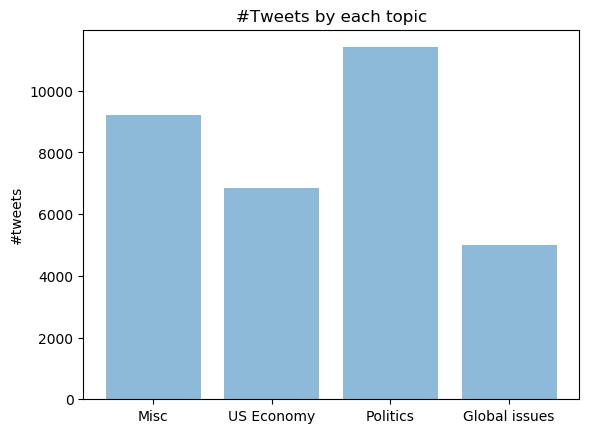

In [13]:
###################################
#EDA #tweets by topic
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt

objects = set(list(Tweet_rate['Category']))
y_pos = np.arange(len(objects))
performance = [len(Tweet_rate[(Tweet_rate['Category']==i)]) for i in set(list(Tweet_rate['Category']))]

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('#tweets')
plt.title('#Tweets by each topic')

plt.show()

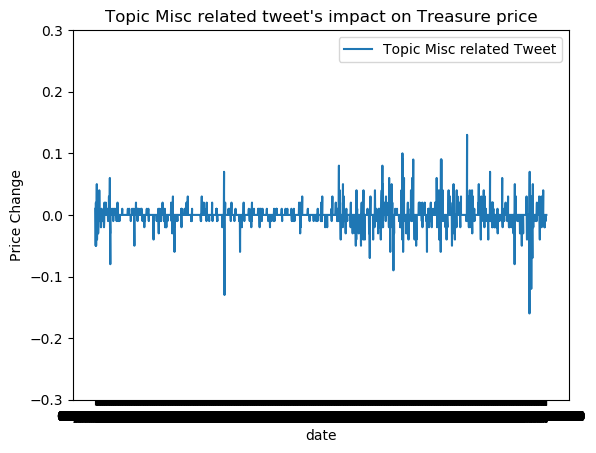

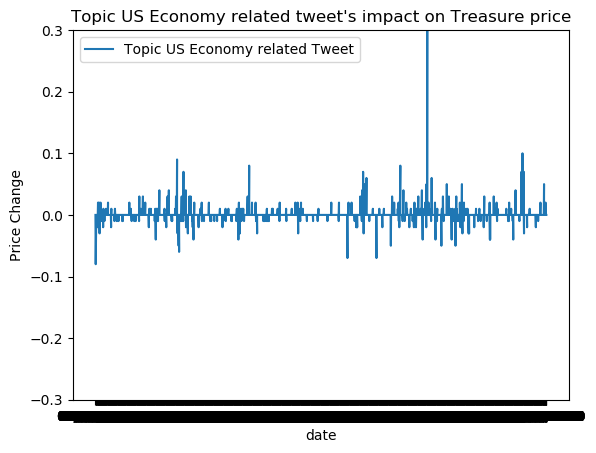

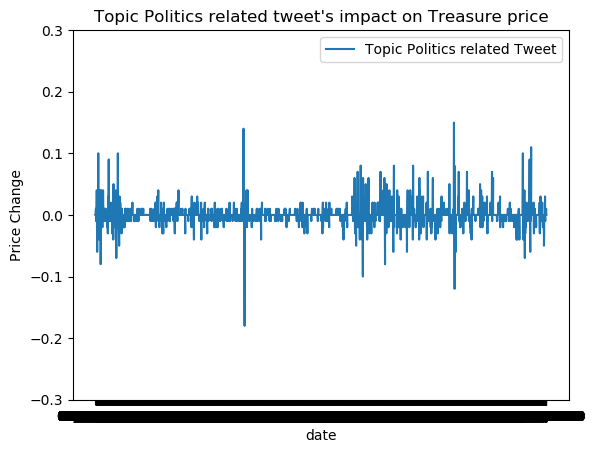

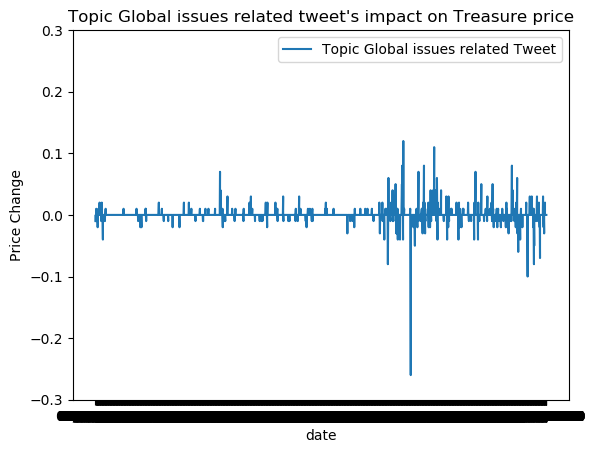

In [14]:
#####
#EDA - Topic impact on price movement

for i in set(list(Tweet_rate['Category'])):
    df5=pd.DataFrame()
    df5=Tweet_rate[(Tweet_rate['Category']==i)]
    plt.plot(df5['date'], df5['1 Mo pric diff'],label=f'Topic {i} related Tweet')
    plt.xlabel('date')
    plt.ylabel('Price Change')
    plt.title(f"Topic {i} related tweet's impact on Treasure price")
    axes = plt.gca()
    axes.set_ylim([-.3,.3])
    plt.legend()
    plt.show()

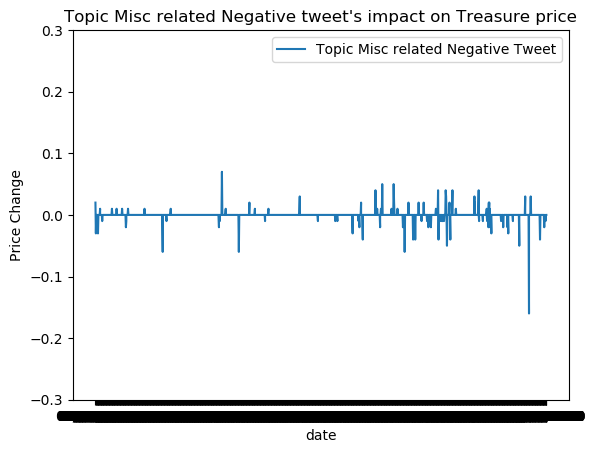

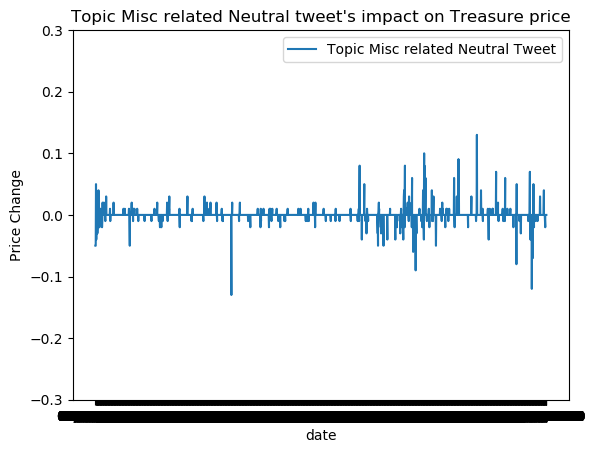

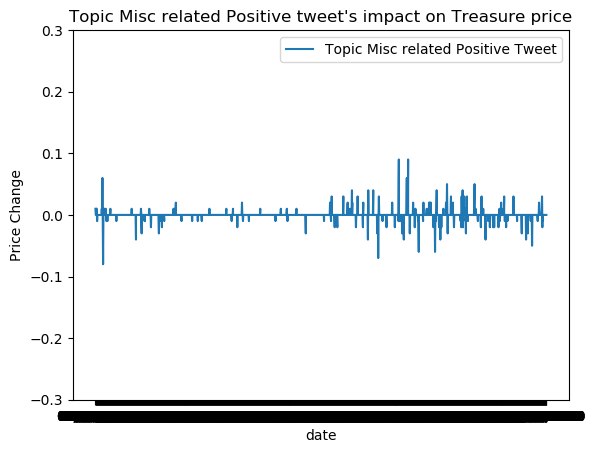

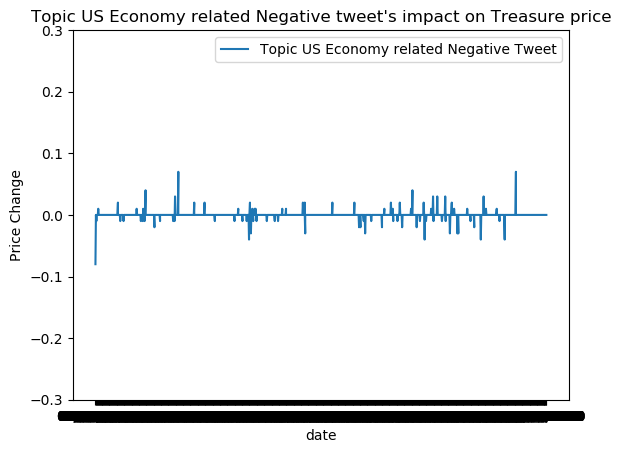

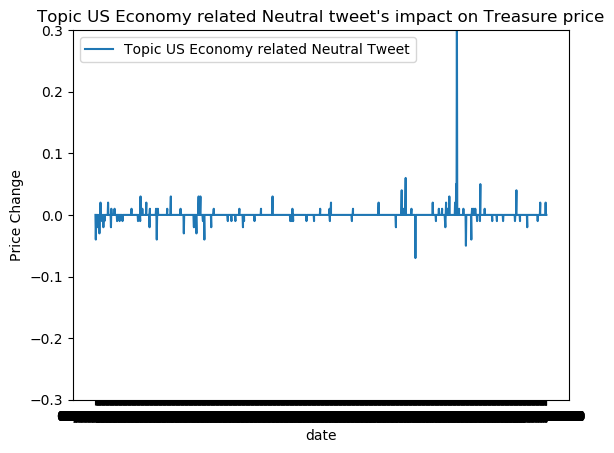

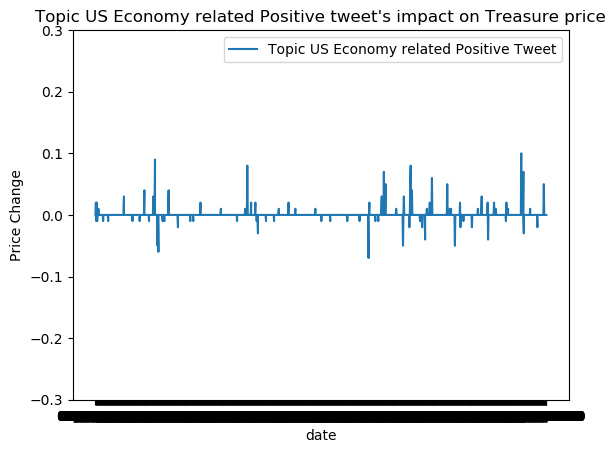

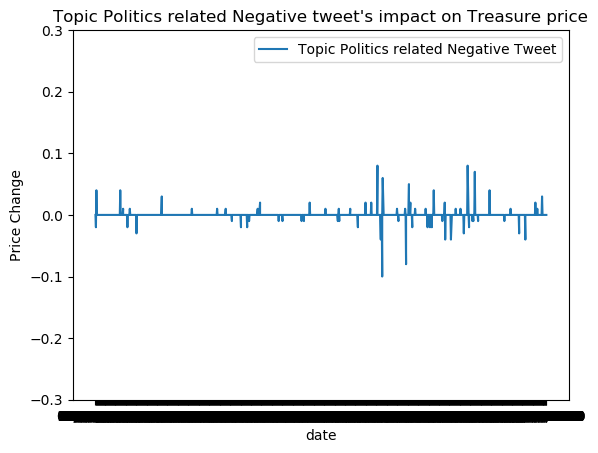

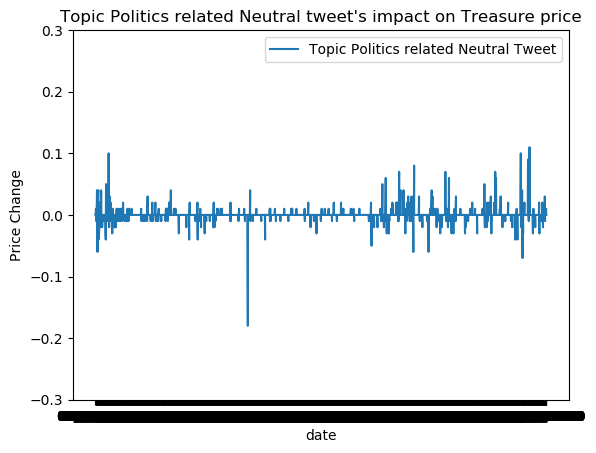

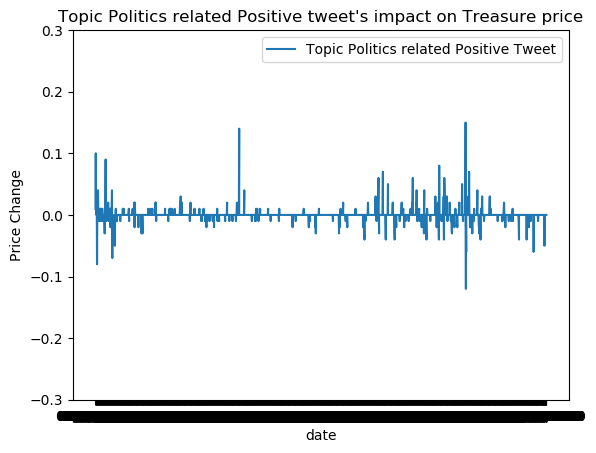

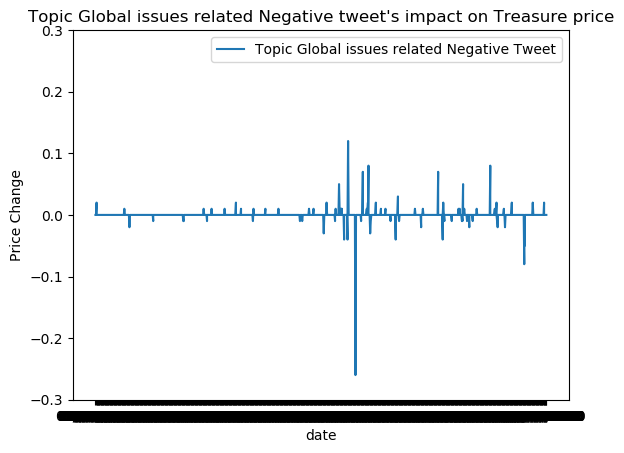

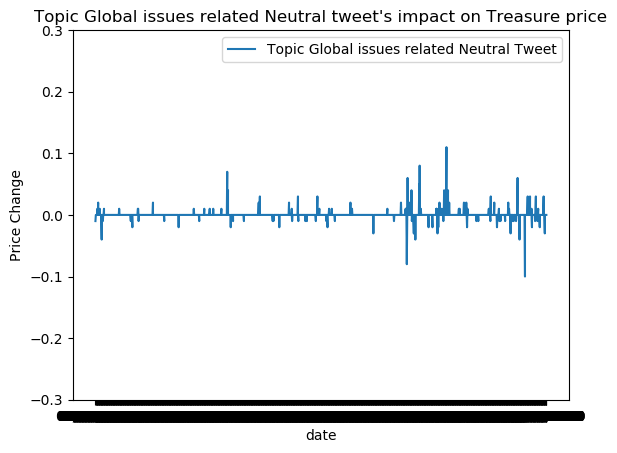

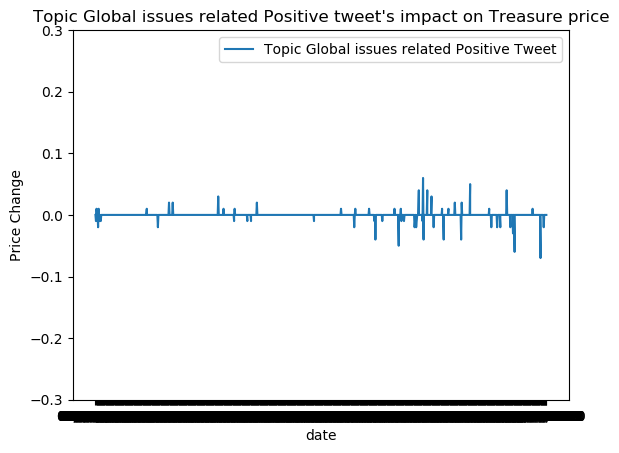

In [15]:
################################################################
#EDA - Topic Sentiment impact on price movement

for i in set(list(Tweet_rate['Category'])):
    for j in set(list(Tweet_rate['SA'])):
        df5=pd.DataFrame()
        df5=Tweet_rate[(Tweet_rate['Category']==i) & (Tweet_rate['SA']==j)]
        plt.plot(df5['date'], df5['1 Mo pric diff'],label=f'Topic {i} related {j} Tweet')
        plt.xlabel('date')
        plt.ylabel('Price Change')
        plt.title(f"Topic {i} related {j} tweet's impact on Treasure price")
        plt.legend()
        axes = plt.gca()
        axes.set_ylim([-.3,.3])
        plt.show()

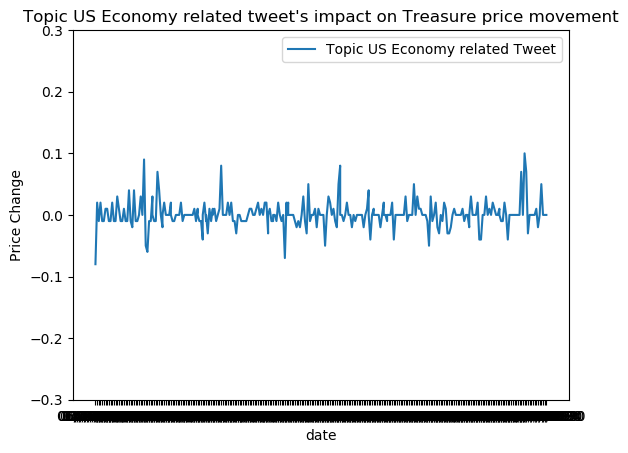

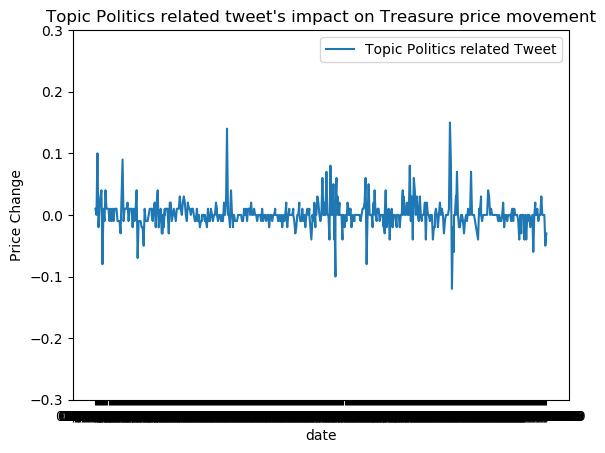

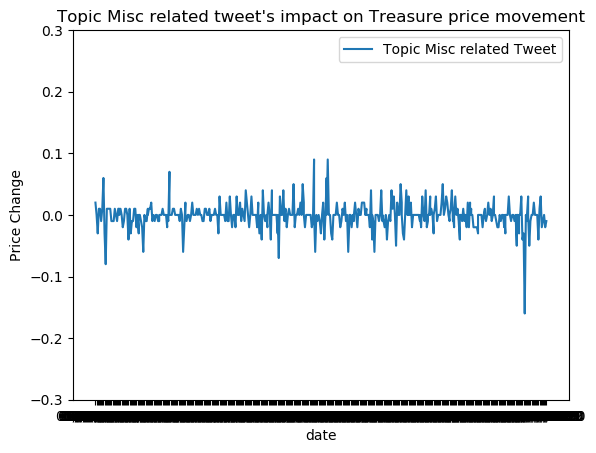

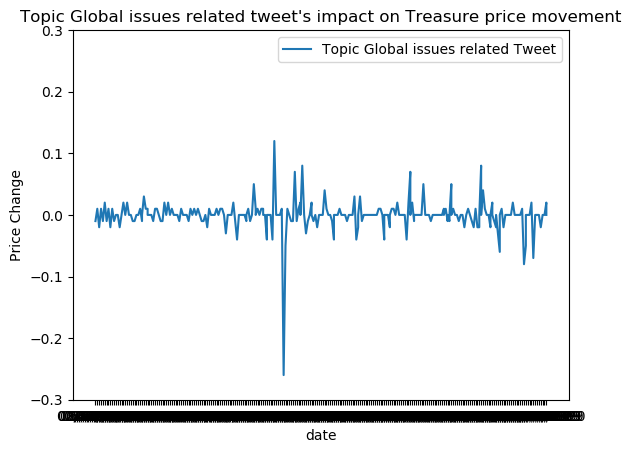

In [16]:
############################
#removing rows with no price movement
df6=Tweet_rate[(Tweet_rate['1 Mo flag']!="neutral") & (Tweet_rate['SA']!="Neutral")]
############
#EDA - Topic impact on price movement
for i in set(list(df6['Category'])):
    df5_1=pd.DataFrame()
    df5_1=df6[(df6['Category']==i)]
    plt.plot(df5_1['date'], df5_1['1 Mo pric diff'],label=f'Topic {i} related Tweet')
    plt.xlabel('date')
    plt.ylabel('Price Change')
    plt.title(f"Topic {i} related tweet's impact on Treasure price movement")
    plt.legend()
    axes = plt.gca()
    axes.set_ylim([-.3,.3])
    plt.show()

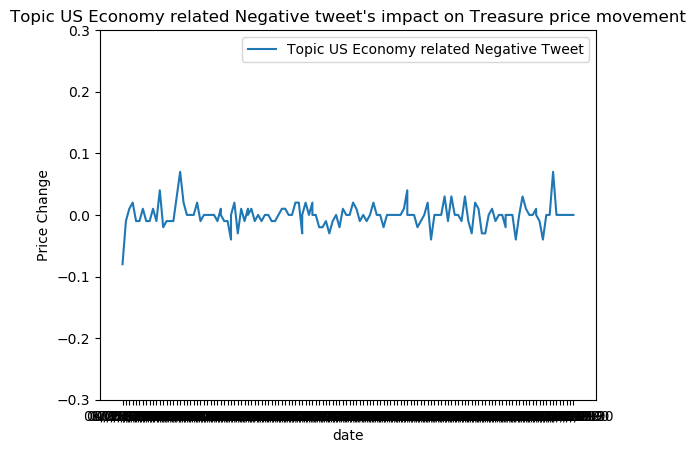

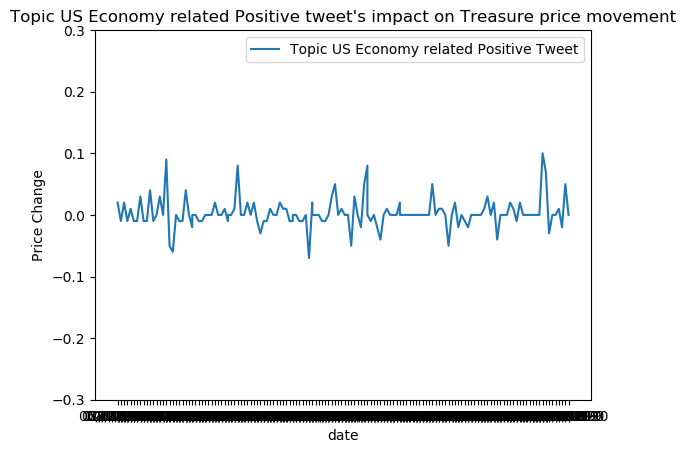

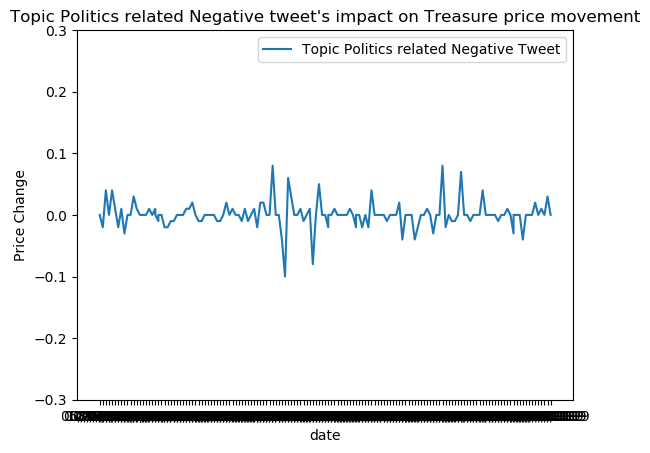

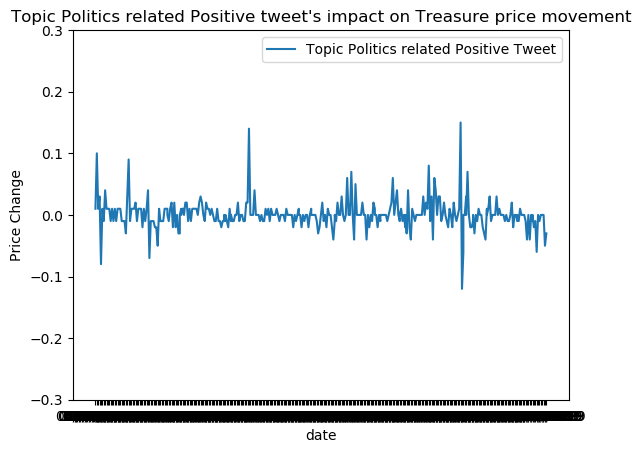

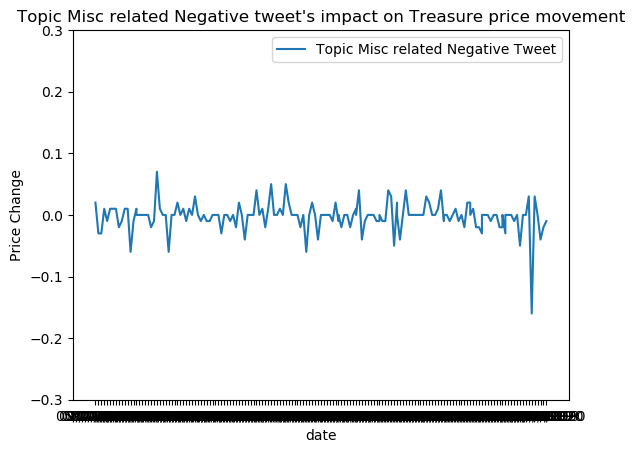

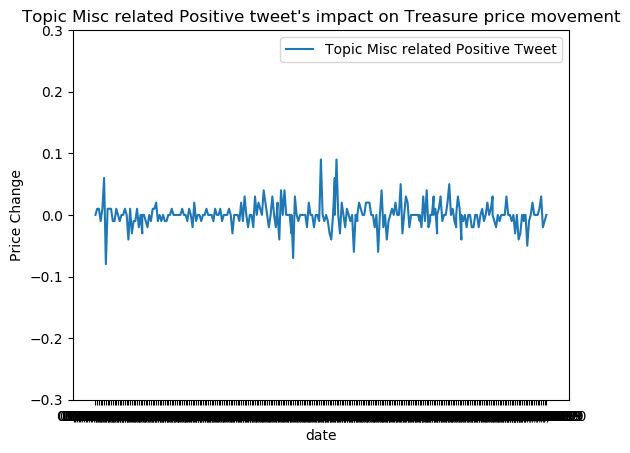

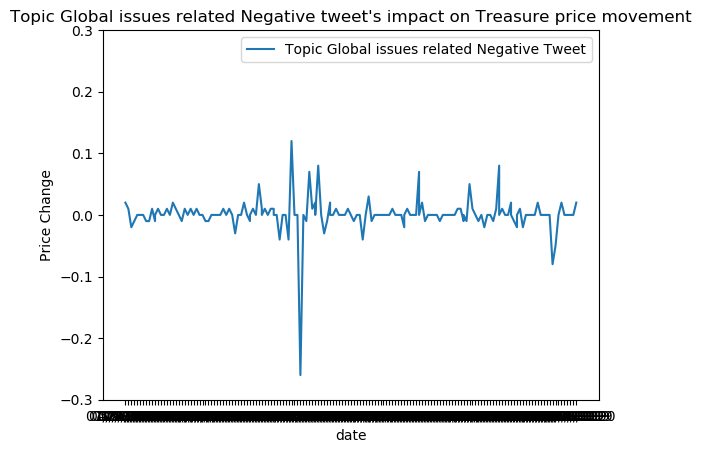

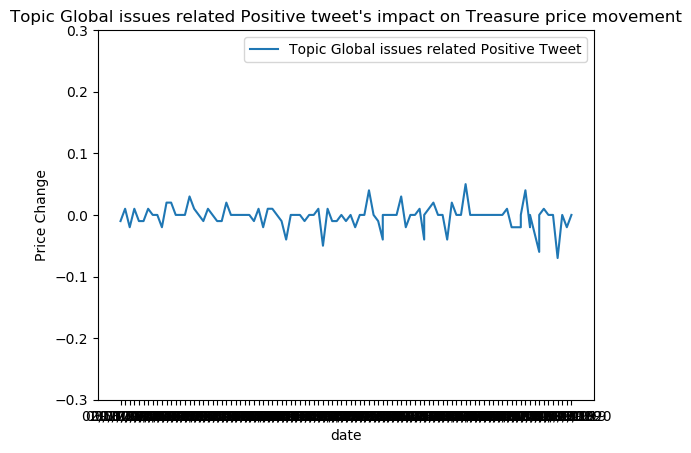

In [17]:
############
#EDA - Topic sentiment impact on price movement
for i in set(list(df6['Category'])):
    for j in set(list(df6['SA'])):
        df5_1=pd.DataFrame()
        df5_1=df6[(df6['Category']==i) & (df6['SA']==j)]
        plt.plot(df5_1['date'], df5_1['1 Mo pric diff'],label=f'Topic {i} related {j} Tweet')
        plt.xlabel('date')
        plt.ylabel('Price Change')
        plt.title(f"Topic {i} related {j} tweet's impact on Treasure price movement")
        plt.legend()
        axes = plt.gca()
        axes.set_ylim([-.3,.3])
        plt.show()

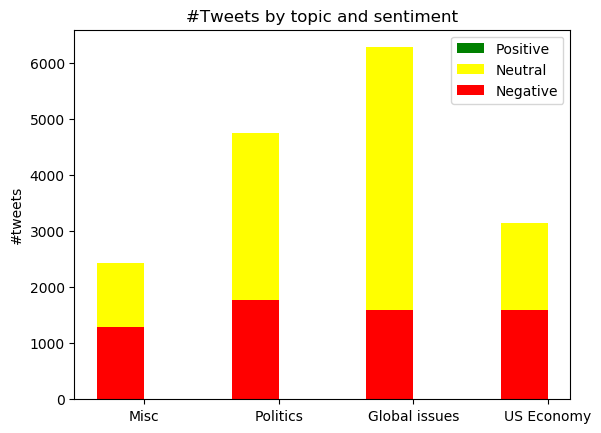

In [18]:
##########################
#reviews_df.head()
df7=Tweet_rate[["SA",'Category']]
df8=pd.pivot_table(df7,columns=["SA"],index=['Category'],aggfunc=len)

#EDA - #Positive/Neutral/Negative tweets
positive = list(df8['Positive'])
negative = list(df8['Negative'])
neutral = list(df8['Neutral'])

ind = np.arange(len(positive))  # the x locations for the groups
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(ind - width/2, positive, width, label='Positive',color='green')
rects2 = ax.bar(ind - width/2, neutral, width, label='Neutral',color='yellow')
rects3 = ax.bar(ind - width/2, negative, width, label='Negative',color='red')
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('#tweets')
ax.set_title('#Tweets by topic and sentiment')
ax.set_xticks(ind)
ax.set_xticklabels(['Misc','Politics','Global issues','US Economy'])
ax.legend()
plt.show()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


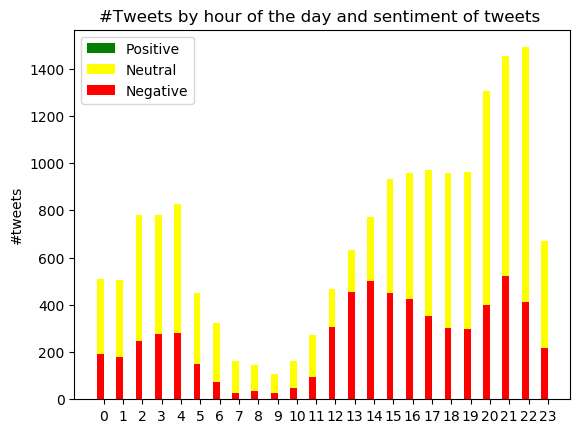

In [19]:
##############
df9=Tweet_rate[['hour',"SA"]]
df10=[]
for i in df9['hour']:
    df10.append(int(i))
df9['hour']=df10
#EDA Tweets by hour of the day
df11=pd.pivot_table(df9,columns=["SA"],index=['hour'],aggfunc=len)
positive1 = list(df11['Positive'])
negative1 = list(df11['Negative'])
neutral1 = list(df11['Neutral'])

ind1 = np.arange(len(positive1))  # the x locations for the groups
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(ind1 - width/2, positive1, width, label='Positive',color='green')
rects2 = ax.bar(ind1 - width/2, neutral1, width, label='Neutral',color='yellow')
rects3 = ax.bar(ind1 - width/2, negative1, width, label='Negative',color='red')
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('#tweets')
ax.set_title('#Tweets by hour of the day and sentiment of tweets ')
ax.set_xticks(ind1)
ax.set_xticklabels((set(df9['hour'])))
ax.legend()
plt.show()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


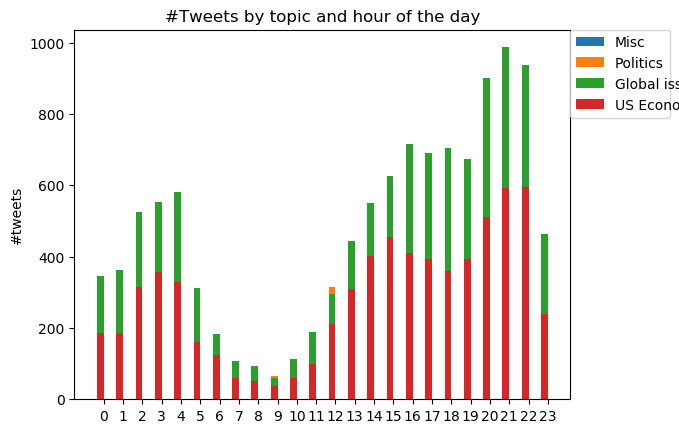

In [20]:
###################
# EDA Tweet sentiment by hour of the day
df10=df9
df10['Category']=df7['Category']
df10=df10.drop(['SA'],axis=1)
df12=pd.pivot_table(df10,columns=["Category"],index=['hour'],aggfunc=len)
Topic1=df12.iloc[:,0]
Topic2=df12.iloc[:,1]
Topic3=df12.iloc[:,2]
Topic4=df12.iloc[:,3]

ind2 = np.arange(len(Topic1))  # the x locations for the groups
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(ind2 - width/2, Topic1, width, label='Misc')
rects2 = ax.bar(ind2 - width/2, Topic2, width, label='Politics')
rects3 = ax.bar(ind2 - width/2, Topic3, width, label='Global issues')
rects4 = ax.bar(ind2 - width/2, Topic4, width, label='US Economy')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('#tweets')
ax.set_title('#Tweets by topic and hour of the day')
ax.set_xticks(ind2)
ax.set_xticklabels((set(df9['hour'])))
ax.legend(bbox_to_anchor=(2, 1), loc=2, borderaxespad=0.)
plt.legend(bbox_to_anchor=(1,0.0,0.2,1), loc='upper center',mode='expand',
           ncol=1, borderaxespad=0.,fontsize=10)
plt.show()

In [21]:
#####################
#Logistic Regression

# Importing the dataset and reading age and salary to X, let's assume we are just looking for this only
df2=df6

df2=df2[['date', 'hour','content', '1 Mo', '1 Mo flag', '1 Mo pric diff',
       'content_processed', 'SA','Category']]
df=df2[df2['1 Mo flag'].notna()]
one_hot=pd.get_dummies(df['Category'])
df=df.drop('Category',axis=1)
df=df.join(one_hot)
one_hot=pd.get_dummies(df['SA'])
df=df.drop('SA',axis=1)
df=df.join(one_hot)

df_train = df[0:1100]
df_test = df[1100:]

X_train = df_train.iloc[:, 8:].values
y_train = df_train.iloc[:, 4].values

X_test = df_test.iloc[:, 8:].values
y_test = df_test.iloc[:, 4].values

# Fitting Logistic Regression to the Training set
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression()
classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test)

#************************************Evaluating the model***********************************

# Making the Confusion Matrix
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
cm = confusion_matrix(y_test, y_pred)

#Validating the Regression Model using the score
# How can you validate the score manually from the confusion matrix
classifier.score(X_test, y_test)

# Calculating the TP,TN,FP and FN ,,, these are used for calculating specificity and sensitivity
TP = cm[1, 1]
TN = cm[0, 0]
FP = cm[0, 1]
FN = cm[1, 0]

#Classification Accuracy: Overall, how often is the classifier correct? Does it match as above

print("Accuracy: {}%".format(((TP + TN)*100 / float(TP + TN + FP + FN)).round(2)))

#Classification Error: Overall, how often is the classifier incorrect? Also known as "Misclassification Rate"

classification_error = ((FP + FN)*100 / float(TP + TN + FP + FN)).round(2)
print("classification_error: {}%".format(classification_error))

#*******Sensitivity**********

sensitivity = (TP*100 / float(FN + TP)).round(2)
print("sensitivity: {}%".format(sensitivity))

#*******Specificity**********
specificity = (TN *100/ (TN + FP)).round(2)
print("specificity: {}%".format(specificity))

print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print("accuracy_score: {}%".format((accuracy_score(y_test, y_pred)*100).round(2)))

Accuracy: 52.66%
classification_error: 47.34%
sensitivity: 40.46%
specificity: 62.16%
[[138  84]
 [103  70]]
              precision    recall  f1-score   support

        down       0.57      0.62      0.60       222
          up       0.45      0.40      0.43       173

    accuracy                           0.53       395
   macro avg       0.51      0.51      0.51       395
weighted avg       0.52      0.53      0.52       395

accuracy_score: 52.66%


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
